### Слияние данных в один датасет и предобрабока. 

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from matplotlib import pyplot as plt

"""
D_clients.csv
D_close_loan.csv
D_job.csv
D_last_credit.csv
D_loan.csv
D_pens.csv
D_salary.csv
D_target.csv
D_work.csv
"""


#df = pd.read_csv("datasets/bank-mix.csv")
#df.head()

df_clients = pd.read_csv("datasets/D_clients.csv")
df_loan = pd.read_csv("datasets/D_loan.csv")
df_close_loan = pd.read_csv("datasets/D_close_loan.csv")
df_salary = pd.read_csv("datasets/D_salary.csv")
df_last_credit = pd.read_csv("datasets/D_last_credit.csv")
df_target = pd.read_csv("datasets/D_target.csv")
df_job = pd.read_csv("datasets/D_job.csv")

Сначала сливаем с таргетом. там будут пропуски (не у всех клиентов известен отклик), но они нам неинтересны, поэтому делаем правый джоин чтобы они сразу удалились



In [3]:
df_cl_t = pd.merge(df_clients, df_target, how = "right", left_on = "ID", right_on = "ID_CLIENT" )

In [4]:
df_cl_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       15223 non-null  int64 
 1   AGE                      15223 non-null  int64 
 2   GENDER                   15223 non-null  int64 
 3   EDUCATION                15223 non-null  object
 4   MARITAL_STATUS           15223 non-null  object
 5   CHILD_TOTAL              15223 non-null  int64 
 6   DEPENDANTS               15223 non-null  int64 
 7   SOCSTATUS_WORK_FL        15223 non-null  int64 
 8   SOCSTATUS_PENS_FL        15223 non-null  int64 
 9   REG_ADDRESS_PROVINCE     15223 non-null  object
 10  FACT_ADDRESS_PROVINCE    15223 non-null  object
 11  POSTAL_ADDRESS_PROVINCE  15223 non-null  object
 12  FL_PRESENCE_FL           15223 non-null  int64 
 13  OWN_AUTO                 15223 non-null  int64 
 14  AGREEMENT_RK             15223 non-nul

In [5]:
df_loan.columns, df_close_loan.columns, df_last_credit.columns, df_clients.columns

(Index(['ID_LOAN', 'ID_CLIENT'], dtype='object'),
 Index(['ID_LOAN', 'CLOSED_FL'], dtype='object'),
 Index(['CREDIT', 'TERM', 'FST_PAYMENT', 'ID_CLIENT'], dtype='object'),
 Index(['ID', 'AGE', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CHILD_TOTAL',
        'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL',
        'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE',
        'POSTAL_ADDRESS_PROVINCE', 'FL_PRESENCE_FL', 'OWN_AUTO'],
       dtype='object'))

Смержим таблицы кредитов по ID_LOAN (left join, нас не интересуют закрытые кредиты по которым нет связи c ID_CLIENT)
далее агрегируем по ID_CLIENT - получаем по каждому клиенту сколько брал кредитов, сколько вернул на даный момент

In [6]:
df_credits = pd.merge(df_loan, df_close_loan, how = "left", on = "ID_LOAN")
df_client_credits = df_credits[["ID_CLIENT","CLOSED_FL"]].groupby("ID_CLIENT").aggregate(["count","sum"])
df_client_credits.columns = ["credits","closed"]

In [7]:
df_client_credits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15223 entries, 106804370 to 106819592
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   credits  15223 non-null  int64
 1   closed   15223 non-null  int64
dtypes: int64(2)
memory usage: 356.8 KB


Точно также приклеим данные по зарплате (left join)

In [8]:
df_mix_tmp = pd.merge(df_cl_t, df_client_credits, how = "left", left_on = "ID", right_on = "ID_CLIENT")
df_mix_tmp_1 = pd.merge(df_mix_tmp, df_salary, how = "left", left_on = "ID", right_on = "ID_CLIENT")
df_mix = pd.merge(df_mix_tmp_1, df_job, how = "left", left_on = "ID", right_on = "ID_CLIENT")\
                    .drop("ID_CLIENT", axis=1)
df_mix.head(2)

,ID,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,...,TARGET,credits,closed,FAMILY_INCOME,PERSONAL_INCOME,ID_CLIENT_y,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,WORK_TIME
0,106804370,49,1,Среднее специальное,Состою в браке,2,1,1,0,Оренбургская область,...,0,1,1,от 10000 до 20000 руб.,5000.0,106804370,Торговля,Рабочий,Вспомогательный техперсонал,18.0
1,106804370,49,1,Среднее специальное,Состою в браке,2,1,1,0,Оренбургская область,...,0,1,1,от 10000 до 20000 руб.,5000.0,106804370,Торговля,Рабочий,Вспомогательный техперсонал,18.0


In [9]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15523 entries, 0 to 15522
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       15523 non-null  int64  
 1   AGE                      15523 non-null  int64  
 2   GENDER                   15523 non-null  int64  
 3   EDUCATION                15523 non-null  object 
 4   MARITAL_STATUS           15523 non-null  object 
 5   CHILD_TOTAL              15523 non-null  int64  
 6   DEPENDANTS               15523 non-null  int64  
 7   SOCSTATUS_WORK_FL        15523 non-null  int64  
 8   SOCSTATUS_PENS_FL        15523 non-null  int64  
 9   REG_ADDRESS_PROVINCE     15523 non-null  object 
 10  FACT_ADDRESS_PROVINCE    15523 non-null  object 
 11  POSTAL_ADDRESS_PROVINCE  15523 non-null  object 
 12  FL_PRESENCE_FL           15523 non-null  int64  
 13  OWN_AUTO                 15523 non-null  int64  
 14  AGREEMENT_RK          

In [87]:
df_mix.to_csv("datasets/final.csv")

In [88]:
df_mix["TARGET"].isna().sum()

0

In [12]:
df_mix.columns

Index(['ID', 'AGE', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CHILD_TOTAL',
       'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL',
       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE',
       'POSTAL_ADDRESS_PROVINCE', 'FL_PRESENCE_FL', 'OWN_AUTO', 'AGREEMENT_RK',
       'ID_CLIENT_x', 'TARGET', 'credits', 'closed', 'FAMILY_INCOME',
       'PERSONAL_INCOME', 'ID_CLIENT_y', 'GEN_INDUSTRY', 'GEN_TITLE',
       'JOB_DIR', 'WORK_TIME'],
      dtype='object')

In [13]:
df_mix["GENDER"].value_counts()

GENDER
1    10152
0     5371
Name: count, dtype: int64

### Исследование на выбросы

In [67]:
df_num = df_mix.select_dtypes(include=np.number)
df_num = df_num.loc[:, ~df_num.columns.isin(['ID','WORK_TIME','AGREEMENT_RK','ID_CLIENT_x',
                                             'ID_CLIENT_y','TARGET','SOCSTATUS_WORK_FL', 
                                             'SOCSTATUS_PENS_FL','GENDER','OWN_AUTO','FL_PRESENCE_FL'])]
df_num.head(2)

,AGE,CHILD_TOTAL,DEPENDANTS,credits,closed,PERSONAL_INCOME
0,49,2,1,1,1,5000.0
1,49,2,1,1,1,5000.0


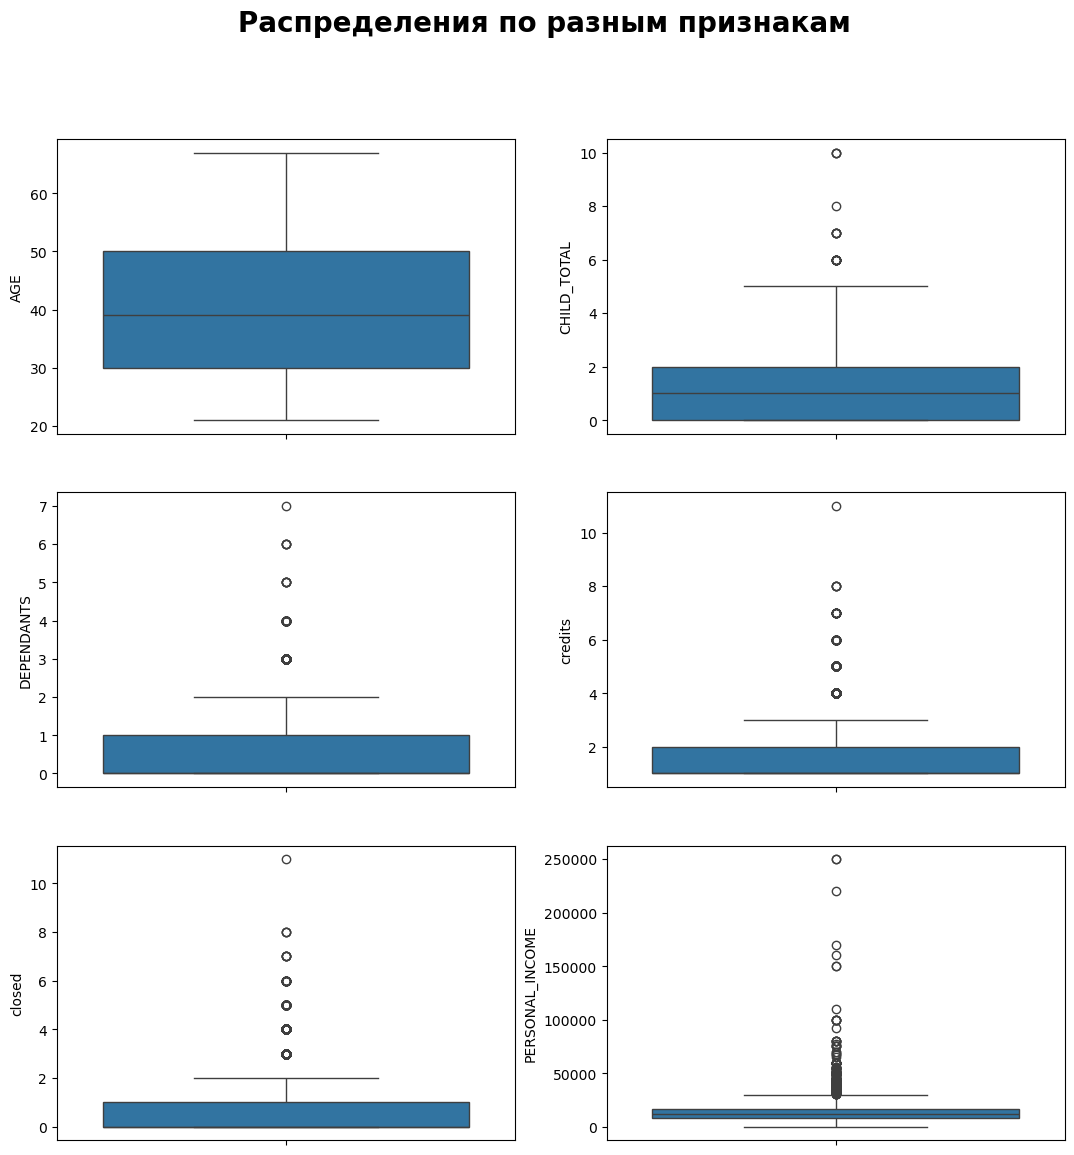

In [69]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13,13))
axs = axs.flatten()

fig.suptitle('Распределения по разным признакам',
             fontsize=20,
             fontweight='bold')

for i, col in enumerate(df_num.columns):
    sns.boxplot(df_num[col], ax=axs[i])    


In [82]:
df_mix[zscore(df_mix['PERSONAL_INCOME']) > 3].sample(3)

,ID,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,...,TARGET,credits,closed,FAMILY_INCOME,PERSONAL_INCOME,ID_CLIENT_y,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,WORK_TIME
14806,106818895,41,0,Высшее,Состою в браке,2,2,1,0,Самарская область,...,1,1,1,свыше 50000 руб.,80000.0,106818895,Торговля,Руководитель высшего звена,Участие в основ. деятельности,72.0
5596,106809843,52,0,Два и более высших образования,Состою в браке,2,0,1,0,Рязанская область,...,1,1,1,свыше 50000 руб.,50000.0,106809843,Нефтегазовая промышленность,Высококвалифиц. специалист,Юридическая служба,9.0
6058,106810296,56,1,Высшее,Разведен(а),1,0,1,0,Калмыкия,...,1,1,0,от 20000 до 50000 руб.,60000.0,106810296,Торговля,Руководитель высшего звена,Участие в основ. деятельности,156.0


In [86]:
df_mix[zscore(df_mix['CHILD_TOTAL']) > 3].sample(3)

,ID,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,...,TARGET,credits,closed,FAMILY_INCOME,PERSONAL_INCOME,ID_CLIENT_y,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,WORK_TIME
2232,106806558,53,1,Среднее,Состою в браке,5,0,0,1,Оренбургская область,...,0,1,0,от 10000 до 20000 руб.,5000.0,106806558,NaN,NaN,NaN,NaN
7964,106812170,51,1,Неполное среднее,Состою в браке,5,0,0,1,Тюменская область,...,0,1,0,от 10000 до 20000 руб.,6000.0,106812170,NaN,NaN,NaN,NaN
2642,106806959,38,1,Среднее,Состою в браке,5,5,1,0,Башкирия,...,0,1,0,от 10000 до 20000 руб.,6000.0,106806959,Другие сферы,Рабочий,Участие в основ. деятельности,24.0


### То что с точки зрения статистики можно принять за выбросами в реальности таковыми не являются